In [1]:
from dotenv import load_dotenv
load_dotenv(".env", override=True)
%load_ext autoreload
%autoreload 2

# Deepagent for Research

We will use the `deepagents` package to create a research agent. When using the `deepagents` package, it's important to: 

1. Understand the native tools available
2. Supply task-specific tools
3. Supply task-specific instructions
4. Supply task-specific sub-agents

## Task-Specific Tools 

You can see an overview of the native tools in the [deepagents package README](https://github.com/langchain-ai/deepagents?tab=readme-ov-file#model) as well as the [quickstarts README](https://github.com/langchain-ai/deepagents-quickstarts). We'll extend this with two task-specific tools. 

### Search Tool 

We'll supply a simple search tool that uses Tavily to search for relevant URLs, then fetches the full webpage content. 

### Think Tool 

We'll supply a [think tool](https://www.anthropic.com/engineering/claude-think-tool), which is a useful way to help audit agent decision making. 

In [5]:
from research_agent.tools import tavily_search, think_tool
tools = [tavily_search, think_tool]

## Task-Specific Instructions
 
Next, let's define task specific instructions using [a few prompting techniques for agents](https://youtu.be/XSZP9GhhuAc?si=zowpViL-2j-vI9hA):

### 1. Think Like The Agent
What instructions would you give a new work colleague?
- **Read the question carefully** - What specific information does the user need?
- **Start with broader searches** - Use broad, comprehensive queries first
- **After each search, pause and assess** - Do I have enough to answer? What's still missing?
- **Execute narrower searches as you gather information** - Fill in the gaps.

### 2. Concrete Heuristics (Prevent "Spin-Out" on excessive tool calls)
Use **Hard Limits** to prevent the research agent from calling tools excessively:
- **Stop when you can answer confidently** - Don't keep searching for perfection.
- **Give it budgets** - Use 2-3 search tool calls for simple queries. Use up to 5 for complex queries.
- **Limit** - Always stop after 5 search tool calls if you cannot find the right source(s).

### 3. Show your thinking
After each search tool calling, use [`think_tool` to analyze the results](https://www.anthropic.com/engineering/claude-think-tool):
- What key information did I find? 
- What's missing?
- Do I have enough to answer the question comprehensively?
- Should I search more or provide my answer?

In [2]:
from utils import show_prompt, format_messages
from research_agent.prompts import (
    RESEARCHER_INSTRUCTIONS,
    RESEARCH_WORKFLOW_INSTRUCTIONS,
    SUBAGENT_DELEGATION_INSTRUCTIONS,
)

In [3]:
show_prompt(RESEARCHER_INSTRUCTIONS)

╭──────────────────────────────────────────────────── Prompt ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│  You are a research assistant conducting research on the user's input topic. For context, today's date is       │
│  {date}.                                                                                                        │
│                                                                                                                 │
│  <Task>                                                                                                         │
│  Your job is to use tools to gather information about the user's input topic.                                   │
│  You can use any of the research tools provided to you to find resources that can help answer the research      │
│  question.                                                                                                      │
│  You can call these tools in series or in parallel, your research is conducted in a tool-calling loop.          │
│  </Task>                                                                                                        │
│                                                                                                                 │
│  <Available Research Tools>                                                                                     │
│  You have access to two specific research tools:                                                                │
│  1. **tavily_search**: For conducting web searches to gather information                                        │
│  2. **think_tool**: For reflection and strategic planning during research                                       │
│  **CRITICAL: Use think_tool after each search to reflect on results and plan next steps**                       │
│  </Available Research Tools>                                                                                    │
│                                                                                                                 │
│  <Instructions>                                                                                                 │
│  Think like a human researcher with limited time. Follow these steps:                                           │
│                                                                                                                 │
│  1. **Read the question carefully** - What specific information does the user need?                             │
│  2. **Start with broader searches** - Use broad, comprehensive queries first                                    │
│  3. **After each search, pause and assess** - Do I have enough to answer? What's still missing?                 │
│  4. **Execute narrower searches as you gather information** - Fill in the gaps                                  │
│  5. **Stop when you can answer confidently** - Don't keep searching for perfection                              │
│  </Instructions>                                                                                                │
│                                                                                                                 │
│  <Hard Limits>                                                                                                  │
│  **Tool Call Budgets** (Prevent excessive searching):                                                           │
│  - **Simple queries**: Use 2-3 search tool calls maximum                                                        │
│  - **Complex queries**: Use up to 5 search tool calls maximum                                                   │
│  - **Always stop**: After 5 search tool calls if you cannot find the right sources                              │
│                                                       

## Task-Specific Sub-Agents

You can specify [custom subagents](https://github.com/langchain-ai/deepagents?tab=readme-ov-file#subagents) as a means of context isolation. 

Here's well define a sub-agent that can search the web for information. 

In [6]:
# Create research sub-agent
research_sub_agent = {
    "name": "research-agent",
    "description": "Delegate research to the sub-agent researcher. Only give this researcher one topic at a time.",
    "system_prompt": RESEARCHER_INSTRUCTIONS,
    "tools": [tavily_search, think_tool],
}

## Putting it all together

### Instructions

Now, we can look at all of our instructions together. 

In [7]:
INSTRUCTIONS = (
    RESEARCH_WORKFLOW_INSTRUCTIONS
    + "\n\n"
    + "=" * 80
    + "\n\n"
    + SUBAGENT_DELEGATION_INSTRUCTIONS
    + "\n\n"
    + "=" * 80
    + "\n\n"
    + RESEARCHER_INSTRUCTIONS
)

show_prompt(INSTRUCTIONS)

╭──────────────────────────────────────────────────── Prompt ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│  # Research Workflow                                                                                            │
│                                                                                                                 │
│  Follow this workflow for all research requests:                                                                │
│                                                                                                                 │
│  1. **Save the request**: Use write_file() to save the user's research question to `/research_request.md`       │
│  2. **Plan**: Create a todo list with write_todos to break down the research into focused tasks                 │
│  3. **Research**: Delegate research tasks to sub-agents using the task() tool                                   │
│  4. **Write Report**: Write a comprehensive final report to `/final_report.md` (see Report Writing Guidelines   │
│  below)                                                                                                         │
│  5. **Verify**: Read `/research_request.md` to confirm you've addressed all aspects of the original question    │
│                                                                                                                 │
│  ## Research Planning Guidelines                                                                                │
│  - Batch similar research tasks into a single TODO to minimize overhead                                         │
│  - For simple fact-finding questions, use 1 sub-agent                                                           │
│  - For comparisons or multi-faceted topics, delegate to multiple parallel sub-agents                            │
│  - Each sub-agent should research one specific aspect and return findings                                       │
│                                                                                                                 │
│  ## Report Writing Guidelines                                                                                   │
│                                                                                                                 │
│  When writing the final report to `/final_report.md`, follow these structure patterns:                          │
│                                                                                                                 │
│  **For comparisons:**                                                                                           │
│  1. Introduction                                                                                                │
│  2. Overview of topic A                                                                                         │
│  3. Overview of topic B                                                                                         │
│  4. Detailed comparison                                                                                         │
│  5. Conclusion                                                                                                  │
│                                                                                                                 │
│  **For lists/rankings:**                                                                                        │
│  Simply list items with details - no introduction needed:                                                       │
│  1. Item 1 with explanation                                                                                     │
│  2. Item 2 with explanation                                                                                     │
│  3. Item 3 with explanation                           

### Create the agent

Now, we create our deepagent with these components. 

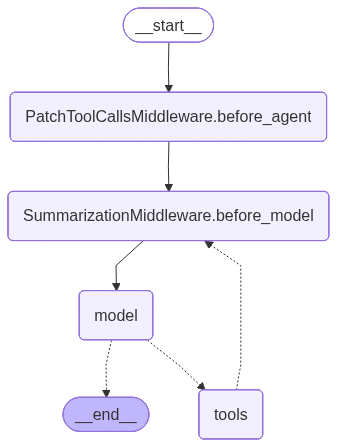

In [8]:
from datetime import datetime
from IPython.display import Image, display
from langchain.chat_models import init_chat_model
from deepagents import create_deep_agent

# Model 
model = init_chat_model(model="anthropic:claude-sonnet-4-5-20250929", temperature=0.0)

# Create the agent
agent = create_deep_agent(
      model=model,
      tools=[tavily_search, think_tool], 
      system_prompt=INSTRUCTIONS,
      subagents=[research_sub_agent],
  )
  
# Show the agent
display(Image(agent.get_graph().draw_mermaid_png()))

In [9]:
result = agent.invoke(
    {
        "messages": [
            {
                "role": "user",
                "content": "Give me an overview of context engineering.",
            }
        ],
    }
)

format_messages(result["messages"])

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ Give me an overview of context engineering.                                                                     │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ I'll research context engineering for you and provide a comprehensive overview.                                 │
│                                                                                                                 │
│ 🔧 Tool Call: write_file                                                                                        │
│    Args: {                                                                                                      │
│   "file_path": "/research_request.md",                                                                          │
│   "content": "# Research Request\n\nGive me an overview of context engineering.\n"                              │
│ }                                                                                                               │
│    ID: toolu_01BdGT4832TaQtyJr4S8tm6w                                                                           │
│                                                                                                                 │
│ 🔧 Tool Call: write_todos                                                                                       │
│    Args: {                                                                                                      │
│   "todos": [                                                                                                    │
│     {                                                                                                           │
│       "content": "Research context engineering - gather information about definition, techniques, applications, │
│ and best practices",                                                                                            │
│       "status": "in_progress"                                                                                   │
│     },                                                                                                          │
│     {                                                                                                           │
│       "content": "Write comprehensive final report to /final_report.md",                                        │
│       "status": "pending"                                                                                       │
│     },                                                                                                          │
│     {                                                                                                           │
│       "content": "Verify report addresses the original research question",                                      │
│       "status": "pending"                                                                                       │
│     }                                                                                                           │
│   ]                                                                                                             │
│ }                                                                                                               │
│    ID: toolu_01U6QVx1F9mRTh9YRGao2Ddm                                                                           │
│                                                                                                                 │
│ 🔧 Tool Call: task                                                                                              │
│    Args: {                                                                                                      │
│   "subagent_type": "research-agent",                                                                            │
│   "description": "Research context engineering comprehensively. I need you to find information about:\n\n1.     │
│ What context engineering is (definition and core concepts)

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Updated file /research_request.md                                                                               │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Updated todo list to [{'content': 'Research context engineering - gather information about definition,          │
│ techniques, applications, and best practices', 'status': 'in_progress'}, {'content': 'Write comprehensive final │
│ report to /final_report.md', 'status': 'pending'}, {'content': 'Verify report addresses the original research   │
│ question', 'status': 'pending'}]                                                                                │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Based on my comprehensive research, here's a detailed report on context engineering:                            │
│                                                                                                                 │
│ ---                                                                                                             │
│                                                                                                                 │
│ # Context Engineering: A Comprehensive Guide                                                                    │
│                                                                                                                 │
│ ## Executive Summary                                                                                            │
│                                                                                                                 │
│ Context engineering represents a fundamental evolution in AI development, moving beyond simple prompt crafting  │
│ to orchestrate entire information environments around AI interactions. This systematic discipline is            │
│ transforming how we build intelligent conversational AI systems that truly understand and respond to complex    │
│ user needs.                                                                                                     │
│                                                                                                                 │
│ ---                                                                                                             │
│                                                                                                                 │
│ ## 1. What is Context Engineering? (Definition and Core Concepts)                                               │
│                                                                                                                 │
│ ### Definition                                                                                                  │
│                                                                                                                 │
│ **Context engineering** is the systematic discipline of designing AI systems that dynamically assemble all      │
│ relevant information, tools, and data in the optimal format to ensure intelligent, personalized responses [1].  │
│ More specifically, it involves designing workflows and architectures that ensure AI models receive all relevant │
│ information, tools, and data in the optimal format at precisely the right moment to complete tasks effectively  │
│ [1].                                                                                                            │
│                                                                                                                 │
│ Unlike basic prompting, context engineering involves creating comprehensive information frameworks that guide   │
│ AI models toward more accurate and contextually appropriate responses [3]. Think of it as the difference        │
│ between giving someone directions to a destination (prompt engineering) versus being their personal GPS         │
│ system—constantly updating with real-time traffic, road conditions, personal preferences, and alternative       │
│ routes [1].                                                                                                     │
│                                                                                                                 │
│ ### Core Components                                                                                             │
│                                                                                                                 │
│ Context engineering operates on several fundamental pri

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│ 🔧 Tool Call: write_todos                                                                                       │
│    Args: {                                                                                                      │
│   "todos": [                                                                                                    │
│     {                                                                                                           │
│       "content": "Research context engineering - gather information about definition, techniques, applications, │
│ and best practices",                                                                                            │
│       "status": "completed"                                                                                     │
│     },                                                                                                          │
│     {                                                                                                           │
│       "content": "Write comprehensive final report to /final_report.md",                                        │
│       "status": "in_progress"                                                                                   │
│     },                                                                                                          │
│     {                                                                                                           │
│       "content": "Verify report addresses the original research question",                                      │
│       "status": "pending"                                                                                       │
│     }                                                                                                           │
│   ]                                                                                                             │
│ }                                                                                                               │
│    ID: toolu_01RVpEWaHNShsVfxTPLaSLC4                                                                           │
│                                                                                                                 │
│ 🔧 Tool Call: write_file                                                                                        │
│    Args: {                                                                                                      │
│   "file_path": "/final_report.md",                                                                              │
│   "content": "# Context Engineering: A Comprehensive Overview\n\n## What is Context Engineering?\n\nContext     │
│ engineering is the systematic discipline of designing AI systems that dynamically assemble all relevant         │
│ information, tools, and data in the optimal format to ensure intelligent, personalized responses [1]. It        │
│ involves creating comprehensive information frameworks and workflows that ensure AI models receive all relevant │
│ information at precisely the right moment to complete tasks effectively [1].\n\nUnlike basic prompt             │
│ engineering, which focuses on crafting individual instructions, context engineering orchestrates entire         │
│ information environments around AI interactions. Think of it as the difference between giving someone           │
│ directions to a destination versus being their personal GPS system\u2014constantly updating with real-time      │
│ traffic, road conditions, personal preferences, and alternative routes [1].\n\n## Core Principles and           │
│ Components\n\nContext engineering operates on several fun

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Updated todo list to [{'content': 'Research context engineering - gather information about definition,          │
│ techniques, applications, and best practices', 'status': 'completed'}, {'content': 'Write comprehensive final   │
│ report to /final_report.md', 'status': 'in_progress'}, {'content': 'Verify report addresses the original        │
│ research question', 'status': 'pending'}]                                                                       │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Updated file /final_report.md                                                                                   │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│ 🔧 Tool Call: write_todos                                                                                       │
│    Args: {                                                                                                      │
│   "todos": [                                                                                                    │
│     {                                                                                                           │
│       "content": "Research context engineering - gather information about definition, techniques, applications, │
│ and best practices",                                                                                            │
│       "status": "completed"                                                                                     │
│     },                                                                                                          │
│     {                                                                                                           │
│       "content": "Write comprehensive final report to /final_report.md",                                        │
│       "status": "completed"                                                                                     │
│     },                                                                                                          │
│     {                                                                                                           │
│       "content": "Verify report addresses the original research question",                                      │
│       "status": "in_progress"                                                                                   │
│     }                                                                                                           │
│   ]                                                                                                             │
│ }                                                                                                               │
│    ID: toolu_01EvPipH9A1aeWsndDn6SgGY                                                                           │
│                                                                                                                 │
│ 🔧 Tool Call: read_file                                                                                         │
│    Args: {                                                                                                      │
│   "file_path": "/research_request.md"                                                                           │
│ }                                                                                                               │
│    ID: toolu_01LMhw1bohJ6yVdLyj955Lon                                                                           │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Updated todo list to [{'content': 'Research context engineering - gather information about definition,          │
│ techniques, applications, and best practices', 'status': 'completed'}, {'content': 'Write comprehensive final   │
│ report to /final_report.md', 'status': 'completed'}, {'content': 'Verify report addresses the original research │
│ question', 'status': 'in_progress'}]                                                                            │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│      1  # Research Request                                                                                      │
│      2                                                                                                          │
│      3  Give me an overview of context engineering.                                                             │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│ 🔧 Tool Call: write_todos                                                                                       │
│    Args: {                                                                                                      │
│   "todos": [                                                                                                    │
│     {                                                                                                           │
│       "content": "Research context engineering - gather information about definition, techniques, applications, │
│ and best practices",                                                                                            │
│       "status": "completed"                                                                                     │
│     },                                                                                                          │
│     {                                                                                                           │
│       "content": "Write comprehensive final report to /final_report.md",                                        │
│       "status": "completed"                                                                                     │
│     },                                                                                                          │
│     {                                                                                                           │
│       "content": "Verify report addresses the original research question",                                      │
│       "status": "completed"                                                                                     │
│     }                                                                                                           │
│   ]                                                                                                             │
│ }                                                                                                               │
│    ID: toolu_01KC2jxTQ2hZTMas7LJjWh2i                                                                           │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Updated todo list to [{'content': 'Research context engineering - gather information about definition,          │
│ techniques, applications, and best practices', 'status': 'completed'}, {'content': 'Write comprehensive final   │
│ report to /final_report.md', 'status': 'completed'}, {'content': 'Verify report addresses the original research │
│ question', 'status': 'completed'}]                                                                              │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ # Context Engineering: A Comprehensive Overview                                                                 │
│                                                                                                                 │
│ I've completed my research on context engineering. Here's what I found:                                         │
│                                                                                                                 │
│ ## What is Context Engineering?                                                                                 │
│                                                                                                                 │
│ **Context engineering** is the systematic discipline of designing AI systems that dynamically assemble all      │
│ relevant information, tools, and data in the optimal format to ensure intelligent, personalized responses [1].  │
│ Unlike basic prompt engineering (which focuses on crafting individual instructions), context engineering        │
│ orchestrates entire information environments around AI interactions—like being a GPS system that constantly     │
│ updates with real-time information rather than just giving static directions [1].                               │
│                                                                                                                 │
│ ## Core Principles                                                                                              │
│                                                                                                                 │
│ Context engineering operates on several key principles:                                                         │
│                                                                                                                 │
│ - **Dynamic Information Assembly**: Creates adaptive "information packages" that change based on task, user     │
│ history, and current situation                                                                                  │
│ - **Multi-Source Integration**: Pulls from databases, previous conversations, APIs, documents, and real-time    │
│ data simultaneously                                                                                             │
│ - **Format Optimization**: Presents information in the most effective format for each specific task             │
│ - **Temporal Awareness**: Maintains memory of past interactions while staying current with new developments     │
│ - **Relevance Filtering**: Prioritizes which context matters most without overwhelming the system               │
│                                                                                                                 │
│ ## Key Techniques                                                                                               │
│                                                                                                                 │
│ ### 1. Retrieval-Augmented Generation (RAG)                                                                     │
│ The most powerful technique for providing long-term memory to LLMs [2]. It converts conversations into          │
│ searchable vector embeddings, retrieves the most relevant past messages, and inserts them into the context      │
│ window. This keeps the context focused and efficient—like having a perfect librarian who finds exactly what you │
│ need [2].                                                                                                       │
│                                                                                                                 │
│ ### 2. Conversational Summarization                                                                             │
│ Creates concise summaries of conversation history to re

Trace: 

https://smith.langchain.com/public/e23fddb2-c39f-4983-bcd7-1110d014df2c/r